# Goal of this notebook:

For a given data configuration compare the results of (possibly multiple configurations) of classical PCA+linreg/lasso and UNet runs.

Slightly modified version of the "Compare_Results_On_original_grid" notebook. 

We assume that all datasets in the DIRECTORY_OUTPUTS folder come from the same underlying dataset (i.e. only difference is the type of grid, while timesteps, variables etc are the same).

Adapted from the Compare_Results_on_original_grid.ipynb Notebook.

## (Section 4.2.2 and 5.2.3 in thesis)

In [1]:
import os
import glob

import numpy as np
import math

import copy
import re
from datetime import datetime

import gzip
import netCDF4 as nc
import pickle

from braceexpand import braceexpand

import matplotlib.pyplot as plt
import matplotlib


import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
DIRECTORY_DATASETS_INTERPOLATED = "Datasets/Interpolated/"
DIRECTORY_DATASETS_ORIGINAL = "Datasets/Original/"
DIRECTORY_IMAGES = "Images/"
DIRECTORY_OUTPUTS = "Output/Compare_UNet_architectures/"

# Give criteria for the dataset and open all files that match these criteria

In [3]:
def braced_glob(path):
    l = []
    for x in braceexpand(path):
        l.extend(glob.glob(x))
    return l

In [4]:
# dataset parameters. To leave unspecified use: "*"
PREFIX = "HadCM3-flat{-precip*,}"
DO_SHUFFLE = False
ALL_VARIABLES = np.sort(["temp_1","precip","dO18"])#np.sort(["temp_1","precip","dO18"])  # "*" get all possible combinations 
DSET_NR = "*"
# helping vars
shuffle_dict = {True:"shuffle", False:"no-shuffle", "*": "*"}

# wildcards can be used in this filename.
DATASET_FOLDER = "{}_{}_{}_".format(PREFIX, "*", DSET_NR)#shuffle_dict[DO_SHUFFLE]
DATASET_FOLDER = "*" + "-".join(ALL_VARIABLES) # using "*" + "-".join(ALL_VARIABLES) instead of DATASET_FOLDER + ... makes it possible to use ico folders too.
DATASET_FOLDER = os.path.join(DIRECTORY_OUTPUTS, DATASET_FOLDER)


dataset_description_files = []  # list to collect the paths to the configuration files
dataset_folders = []  # list to collect all the matching folders.
folder_exists = False

print("Data folders matching the given specifications:")
for dirname in braced_glob(DATASET_FOLDER):
    print(dirname)
    folder_exists = True
    dataset_folders.append(dirname)
    dataset_description_files.append(os.path.join(dirname, "dataset-description.gz"))
if folder_exists == False:
    raise OSError("There exists no folder for the given specifications")

dataset_descriptions = []
for i, file in enumerate(dataset_description_files):
    with gzip.open(file, 'rb') as f:
        dataset_descriptions.append(pickle.load(f))

Data folders matching the given specifications:
Output/Compare_UNet_architectures/HadCM3-ico_5_no-shuffle_cons1_interp-corners_1_dO18-precip-temp_1
Output/Compare_UNet_architectures/HadCM3-flat_no-shuffle_1_dO18-precip-temp_1


In [5]:
def check_dict_conditions(dic, conditions):
    """
    Test whether dict "dic" fullfills the given conditions "conditions". 
    The latter are given as a array of key-value pairs.
    """
    for key, values in conditions:
        if key in dic.keys():
            if not dic[key] in values:
                return False
        else:
            return False
    return True

In [7]:
model_descriptions = []
testset_predictions = []
model_descriptions_paths = []

# specify the conditions that we want the runs to match
conditions = []#("loss", "MSELoss"),("USE_CYLINDRICAL_PADDING",  True),("USE_COORD_CONV", True), ("S_MODE_TARGETS", ('Pixelwise',))]
               #, ("RUN_NR",1), ("USE_CYLINDRICAL_PADDING",  False),
              #("USE_COORD_CONV", False)]# [("MODELTYPE", "Classical")]


print("Available runs from all previously specified folders, that match specifications:")

i_flat_dataset = -1

for i, dataset_folder in enumerate(dataset_folders):
    if dataset_descriptions[i]["GRID"] == "Regular":
        i_flat_dataset = i
    subdirs = [d for d in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, d))]
    for subdir in subdirs:
        files = [f for f in os.listdir(os.path.join(dataset_folder, subdir)) if os.path.isfile(os.path.join(dataset_folder, subdir, f))]
        if "model_training_description.gz" in files and "predictions.gz" in files:        
            # this is a valid description of a model run. Store path and print description
            with gzip.open(os.path.join(dataset_folder, subdir, "model_training_description.gz"), 'rb') as f:
                tmp_description = pickle.load(f)
                if check_dict_conditions(tmp_description, conditions):  # check if the description satisfies our conditions
                    model_descriptions.append(tmp_description)      
                    model_descriptions_paths.append(os.path.join(dataset_folder, subdir, "model_training_description.gz"))
                    print("Path: ", subdir)
                    # for key, value in model_descriptions[-1].items():
                        # print(key,": ", value)
                    print("\n")
                    if tmp_description["MODELTYPE"] == "UNet" or tmp_description["MODELTYPE"] == "Classical_ico":  # if we open a run that was interpolated from an ico grid...
                        fi = os.path.dirname(model_descriptions_paths[-1])
                        tmp_dset = nc.Dataset(fi + "_6_nbs_r_5_nbs_6_cons1.nc")
                        testset_predictions.append(np.array(tmp_dset.variables["dO18"][:])[:,1:-1,:])
                        model_descriptions[-1]["twice_interpolated"] = False
                    else:
                        fi = os.path.dirname(model_descriptions_paths[-1]) + "_flat_r_5_nbs_6_cons1_r_5_nbs_6_cons1.nc"
                        if os.path.isfile(fi):
                            tmp_dset = nc.Dataset(fi)
                            model_descriptions[-1]["twice_interpolated"] = True
                            model_descriptions.append(copy.deepcopy(tmp_description))   
                            model_descriptions_paths.append(os.path.join(dataset_folder, subdir, "model_training_description.gz"))
                            testset_predictions.append(np.array(tmp_dset.variables["dO18"][:])[:,1:-1,:])
                        with gzip.open(os.path.join(dataset_folder, subdir, "predictions.gz"), 'rb') as g:
                            testset_predictions.append(pickle.load(g)["predictions"])  
                            model_descriptions[-1]["twice_interpolated"] = False
        else:
            print("Encountered Invalid directory")

indices_dataset = len(model_descriptions) * [i_flat_dataset]

Available runs from all previously specified folders, that match specifications:
Path:  -0xb4eecf0bc51a89e


Path:  0x73a3d33d45d81cf6


Path:  -0x59c939c9644cd2d1


Path:  -0x39f24f424678fa8d


Path:  -0x2af1a428d0ed58f7


Path:  0x733aec9ad36b8ed2


Path:  -0xbbb6baeba7d1aca


Path:  -0x269d850aaa25baa9


Path:  classical_-0x6b61818b90a28ee3


Path:  -0x3e4e083ad549554a


Path:  -0x2b4ef4d287af07c8


Path:  -0x5e008a71f7450afc


Path:  -0x6cfcd55c64e6f28f


Path:  -0x2b9c5a345d1c1235


Path:  -0x1e415b9efeb75e1c


Path:  -0x39a8d24453ce7c6d


Path:  0x6576e7bb3ff7d6ef


Path:  -0x3c8c7e92fe985678


Path:  0x1694502457ea41fe


Path:  -0x567015d9e2421bb0


Path:  -0x7cce9452a7f01f0d


Path:  0x292a563e708dc410


Path:  -0x227ec182a88b84a3


Path:  0xa8fed26f2a4f010


Path:  -0x18f52ab1deda33ba


Path:  0x2eca9a8e376a00d2


Path:  -0x499545b75043a2a1


Path:  -0x6a7dfc878d59fe87


Path:  -0x557705cd7b2f9dc2


Path:  0x13f53aac95207893


Path:  -0x107947d8c201f8c7


Path:  -0x1d3e5b0d854

Check that we can handle the specified target variable and collect the required files.

In [8]:
required_files = []
precip_files = []
for i, description in enumerate(dataset_descriptions):
    # print("Target variable:", description["target_variables"])
    if description["target_variables"] == ["dO18"]:
        required_files.append([])
        precip_files.append([])
        for filename in description["files_used"]:
            if "isotopes" in filename:
                required_files[-1].append(filename)
            if "precip" in filename:
                precip_files[-1].append(filename)
    else:
        raise NotImplementedError("Currently only d18O is a valid target variable.")

# Load data, especially ground truth data

In [9]:
# names of datasets to which we want not to be missing at any timestep.
dnames = [DIRECTORY_DATASETS_ORIGINAL+"xnapa_isotopes.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_precip.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_slp.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_temp.nc"]

def get_shared_timesteps(dataset_names):
    """
    Not all datasets share the same timesteps. The biggest problems occur in the slp dataset. We want to exclude all
    time steps where one of the variables is missing
    """
    
    # get indices of elements that are shared for all variables.
    from functools import reduce
    ts = tuple([nc.Dataset(dataset_name,"a").variables["t"][:].data for dataset_name in dataset_names])
    common_dates = reduce(np.intersect1d, ts)
    
    return common_dates

In [10]:
isotopes_all_datasets = []
isotopes_yearly_all_datasets = []

isotopes_all_datasets.append(nc.Dataset(required_files[i_flat_dataset][0], "a"))
if "monthly" in required_files[i_flat_dataset][0]:
    isotopes_yearly_all_datasets.append(nc.Dataset(required_files[i_flat_dataset][0].replace("monthly_",""), "a"))
else:
    isotopes_yearly_all_datasets.append([])

d18O = []

lat = []
lon = []

for i, (dataset, yearly_dataset) in enumerate(zip(isotopes_all_datasets, isotopes_yearly_all_datasets)):
    print(dataset.variables.keys())
    lat.append(dataset.variables["latitude"][:].data[1:-1])
    lon.append(dataset.variables["longitude"][:])

    c_dates = get_shared_timesteps(dnames)
    # get the corresponding indices:
    indices = []
    for j, t in enumerate(dataset.variables["t"][:].data):
        if t in c_dates:
            indices.append(j)
    indices = np.array(indices)
    index_mask = np.logical_and(dataset.variables["t"][indices].data // 360 >= 654, \
                                dataset.variables["t"][indices].data // 360 < 1654)    
    indices = indices[index_mask]  

    d18O.append(np.squeeze(dataset.variables["dO18"][:].data)[indices,1:-1])

dict_keys(['t', 't_bnds', 'longitude', 'latitude', 'level-1_4', 'level-1_5', 'level-1_6', 'h2o', 'dO18', 'dD'])


In [11]:
d18O_train = []

d18O_test = []

for i, description in enumerate(dataset_descriptions):
    d18O_train.append(d18O[0][description["indices_train"],...])

    d18O_test.append(d18O[0][description["indices_test"],...])

In [12]:
# in order to compare with the original dataset 
# we need to rescale the prediction based on the standardization that we used in the model

rescaled_predictions = []

for i, description in enumerate(model_descriptions):
    rescaled_predictions.append([])
    if description["MODELTYPE"] == "UNet" or description["MODELTYPE"] == "Classical_ico" or description["twice_interpolated"] == True:
        rescaled_predictions[-1] = np.expand_dims(testset_predictions[i],axis=1)
    else: 
        for j, mode in enumerate(description["S_MODE_TARGETS"]):
            if mode == "Global":
                std = np.mean(np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True), axis=(1,2), keepdims=True)
                std[std==0] = 1
                mean = np.mean(d18O_train[indices_dataset[i]], axis=(0,1,2), keepdims=True)
                rescaled_predictions[-1].append((testset_predictions[i][:,j,...] * std) + mean)             
            elif mode == "Pixelwise":        
                std = np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
                std[std==0] = 1
                mean = np.mean(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
                rescaled_predictions[-1].append((testset_predictions[i][:,j,...] * std) + mean)   
            elif mode == "Global_mean_pixelwise_std":
                std = np.mean(np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True), axis=(1,2), keepdims=True)
                std[std==0] = 1
                mean = np.mean(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
                rescaled_predictions[-1].append((testset_predictions[i][:,j,...] * std) + mean)           
            elif mode == "Pixelwise_mean_global_std":
                std = np.std(d18O_train[indices_dataset[i]], axis=(0), keepdims=True)
                std[std==0] = 1
                mean = np.mean(d18O_train[indices_dataset[i]], axis=(0,1,2), keepdims=True)
                rescaled_predictions[-1].append((testset_predictions[i][:,j,...] * std) + mean)  
            elif mode == "None":
                rescaled_predictions[-1].append(testset_predictions[i])
            else:
                raise NotImplementedError("{} is not a valid keyword for standardization".format(mode))
        rescaled_predictions[-1] = np.stack(rescaled_predictions[-1],axis=1)

# Plotting

In [13]:
def plot_regular_lattice_map(data, lat, lon, cmap=None, norm=None, show_continents=True, 
                         figsize=(15,10), projection=ccrs.Robinson(), savename=None):
    """
    Plot a single image given in standard. Assume shape is (lat,lon).
    """
    assert len(data.shape) == 2

    if cmap is None:
        cmap = plt.get_cmap("plasma")
    if norm is None:
        dmin = np.amin(data)
        dmax = np.amax(data)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.set_global()
    #remove white line
    data, lon_plot = add_cyclic_point(data, coord = lon)
    lo, la = np.meshgrid(lon_plot, lat)
    layer = ax.pcolormesh(lo, la, data, transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)    
    
    ax.coastlines(alpha=0.5)
    if savename is not None:
        plt.savefig(DIRECTORY_IMAGES+savename)
    plt.show()

In [14]:
# calibrate colorscale such that all simulations share the same min and max
vmin = min([np.amin(r_pred[0]) for r_pred in rescaled_predictions] + [np.amin(gt[0]) for gt in d18O_test])
vmax = max([np.amax(r_pred[0]) for r_pred in rescaled_predictions] + [np.amax(gt[0]) for gt in d18O_test])

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

In [17]:
"""
for i, i_j in enumerate(indices_dataset):
    print(i)
    # for key, value in dataset_descriptions[i_j].items():
        # print(key,": ", value)
    for key, value in model_descriptions[i].items():
        print(key,": ", value)
    plot_regular_lattice_map(rescaled_predictions[i][0,0,...], lat[0], lon[0], norm=norm)
"""
print("Uncomment this to get rescaled sample predictions.")

Uncomment this to get rescaled sample predictions.


In [18]:
def RMSE(predictions, targets):
    from sklearn.metrics import mean_squared_error
    rmse = np.zeros((predictions.shape[1]))
    for i in range(predictions.shape[1]):
        rmse[i] = mean_squared_error(targets[:,i], predictions[:,i], squared=False)
    return rmse

In [19]:
rmse = []
metric = []
for i in range(len(rescaled_predictions)):
    rmse.append(RMSE(d18O_test[i_flat_dataset].reshape(d18O_test[i_flat_dataset].shape[0],-1), \
                     rescaled_predictions[i].reshape(rescaled_predictions[i].shape[0],-1)).reshape(len(lat[0]), len(lon[0])))

    # compute explained variance by dividing rmse by standard-deviation on test set.
    metric.append(- rmse[-1]/np.std(d18O_test[indices_dataset[i]], axis=0).reshape(len(lat[0]), len(lon[0])) + 1 )

In [20]:
def plot_explained_variance(metric, lat, lon, figsize=(15,10), cbar_fontsize=15, projection=ccrs.Robinson(), 
                            title="", cbar_label="", norm=None, cmap=None, title_fontsize=15, savename=None, use_default_bounds=True):
    # plot RMSE/sigma - 1
    assert metric.shape == (len(lat), len(lon))
    
    #set up colormap
    colors = ["#67001f","#b2182b","#d6604d","#f4a582","#fddbc7","#d1e5f0","#92c5de","#4393c3","#2166ac","#053061"]
    
    if use_default_bounds:
        lim = 1 # math.ceil(np.max(metric))
        bounds = np.concatenate((np.array([-1.0,-0.8,-0.6,-0.4,-0.2]),np.linspace(0, lim, 6)))
    if cmap is None:
        cmap= matplotlib.colors.ListedColormap(colors)
    if norm is None:
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
                          
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1,projection = projection)
    ax.set_global()
    #remove white line
    field, lon_plot = add_cyclic_point(metric, coord = lon)
    lo, la = np.meshgrid(lon_plot, lat)
    layer = ax.pcolormesh(lo, la, field, transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
    
    if use_default_bounds:
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
            ticks=bounds,
            spacing='proportional',
            orientation='horizontal',
            label='Discrete intervals, some other units',
        ) 
    else:
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
            spacing='proportional',
            orientation='horizontal',
            label='Discrete intervals, some other units',
        )        
    if cbar_label == "":
        cbar.set_label(r"$R^2$ score", fontsize = cbar_fontsize)
    else:
        cbar.set_label(cbar_label, fontsize = cbar_fontsize)
        
    cbar.ax.tick_params(labelsize=20)
    
    ax.coastlines()

    # calculate the global average metric
    weights = np.tile(np.cos(np.deg2rad(lat))[:,None],len(lon))
    metric_global_av = np.average(metric, weights = weights)
    if title == "":
        ax.set_title(r"$R^2 score$, " + \
                     "Global area weighted average: {:.3f}".format(metric_global_av), fontsize=title_fontsize)
    else:
        ax.set_title(title, fontsize=title_fontsize)
        
    if savename is not None:
        plt.savefig(DIRECTORY_IMAGES+savename)

In [21]:
"""
for i in range(len(metric)):
    print(model_descriptions[i]["RUN_NR"])
    print(model_descriptions[i]["S_MODE_PREDICTORS"])    
    print(model_descriptions[i]["S_MODE_TARGETS"])
    print(dataset_descriptions[indices_dataset[i]]["predictor_variables"])
    
    print(model_descriptions[i]["USE_CYLINDRICAL_PADDING"])
    print(model_descriptions[i]["USE_COORD_CONV"])
    print(model_descriptions[i]["loss"])
    plot_explained_variance(metric[i], lat[0],lon[0], savename="flat_coord_conv_{}.jpg".format(i))
    plt.show()
"""
print("uncomment this to get explained variance of individual runs.")

uncomment this to get explained variance of individual runs.


# Calculate averages over many runs

Average over runs of the same scenario.

In [22]:
# if things that we want to average are not automatically ordered...

groups = []
indices_groups = []

for i in range(len(model_descriptions)):
    
    if "USE_COORD_CONV" in model_descriptions[i].keys():
        matches_group = np.array([model_descriptions[i]["MODELTYPE"]  == model_descriptions[group]["MODELTYPE"] and
                                  model_descriptions[i]["twice_interpolated"]  == model_descriptions[group]["twice_interpolated"] and
                                  model_descriptions[i]["loss"]  == model_descriptions[group]["loss"] and
                                  model_descriptions[i]["USE_COORD_CONV"]  == model_descriptions[group]["USE_COORD_CONV"] and
                                  model_descriptions[i]["USE_CYLINDRICAL_PADDING"]  == model_descriptions[group]["USE_CYLINDRICAL_PADDING"]
                                  for group in groups])
    elif "Classical_flat" == model_descriptions[i]["MODELTYPE"]:
        matches_group = np.array([model_descriptions[i]["MODELTYPE"]  == model_descriptions[group]["MODELTYPE"] and 
                                  model_descriptions[i]["twice_interpolated"]  == model_descriptions[group]["twice_interpolated"] for group in groups])  
    else:
        matches_group = np.array([model_descriptions[i]["MODELTYPE"]  == model_descriptions[group]["MODELTYPE"] for group in groups])    
    """
    matches_group = np.array([dataset_descriptions[indices_dataset[i]]["DO_SHUFFLE"] and dataset_descriptions[indices_dataset[group]]["DO_SHUFFLE"] and \
                              dataset_descriptions[indices_dataset[i]]["DSET_NB"] and dataset_descriptions[indices_dataset[group]]["DSET_NB"]])
    """    
    if matches_group.any():
        indices_groups[np.where(matches_group == True)[0][0]].append(i)
        
    else:
        groups.append(i)
        indices_groups.append([])
        indices_groups[-1].append(i)
        
av_metric = np.zeros((len(groups),*metric[0].shape))
global_mean = np.zeros(len(groups))
global_std = np.zeros(len(groups))
# calculate global means and their standard deviations
for i in range(len(groups)):
    l = len(indices_groups[i])
    group_data = np.zeros((l, *metric[0].shape))
    for j, i_g in enumerate(indices_groups[i]):
        group_data[j] = metric[i_g]
    av_metric[i] = np.average(group_data, axis=0)
    
    weights = np.repeat(np.tile(np.cos(np.deg2rad(lat[0]))[:,None],len(lon[0]))[np.newaxis,...], repeats=l, axis=0)
    global_av_metric = np.average(group_data, weights = weights, axis=(1,2))
    global_mean[i] = np.mean(global_av_metric)
    global_std[i] = np.std(global_av_metric)

MODELTYPE UNet
0.152 +/- 0.006


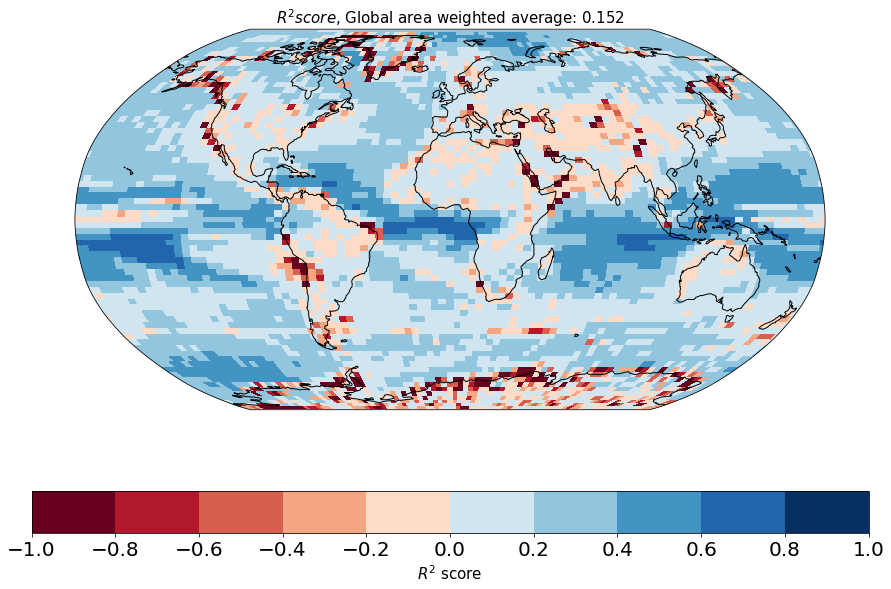

MODELTYPE Classical_ico
0.123 +/- 0.000


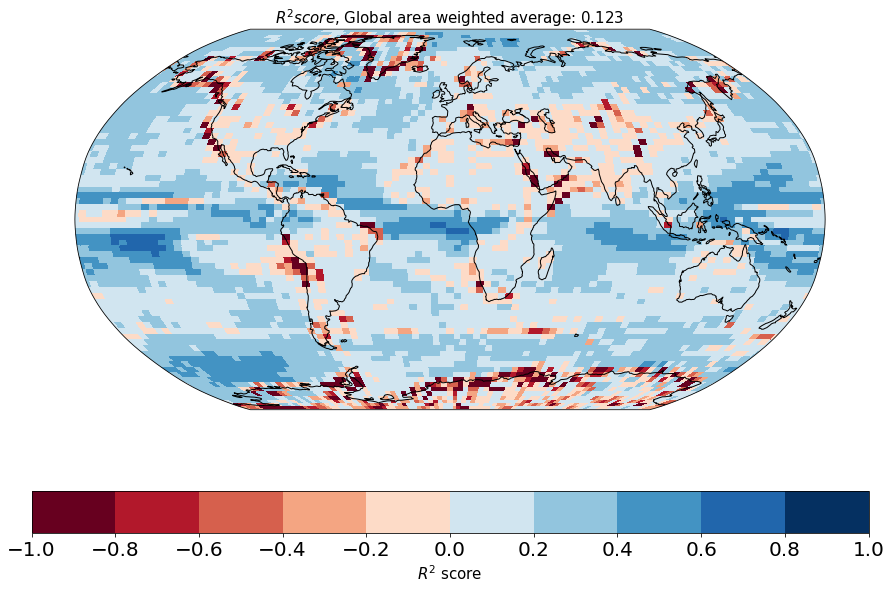

MODELTYPE UNet_flat
MSELoss
Twice interpolated True
False
False
0.137 +/- 0.005


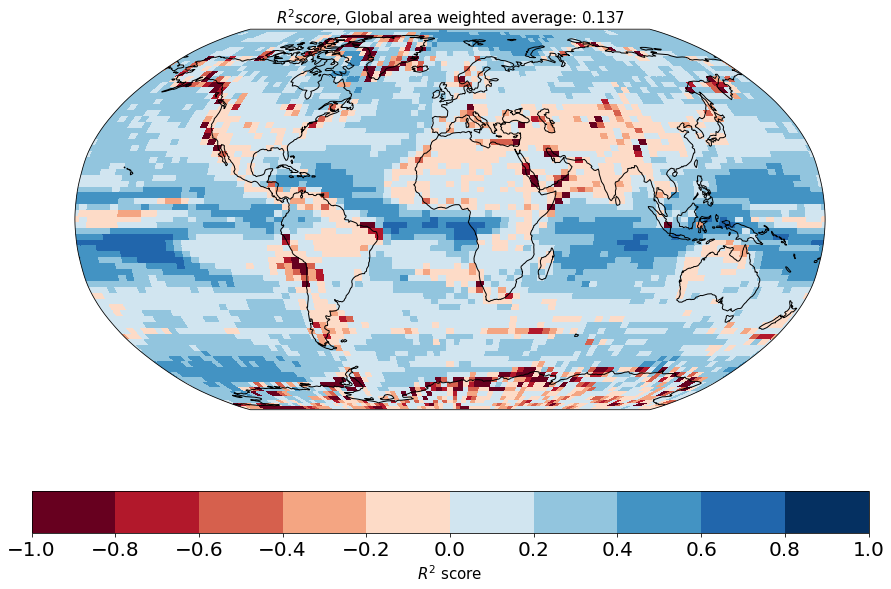

MODELTYPE UNet_flat
MSELoss
Twice interpolated False
False
False
0.222 +/- 0.005


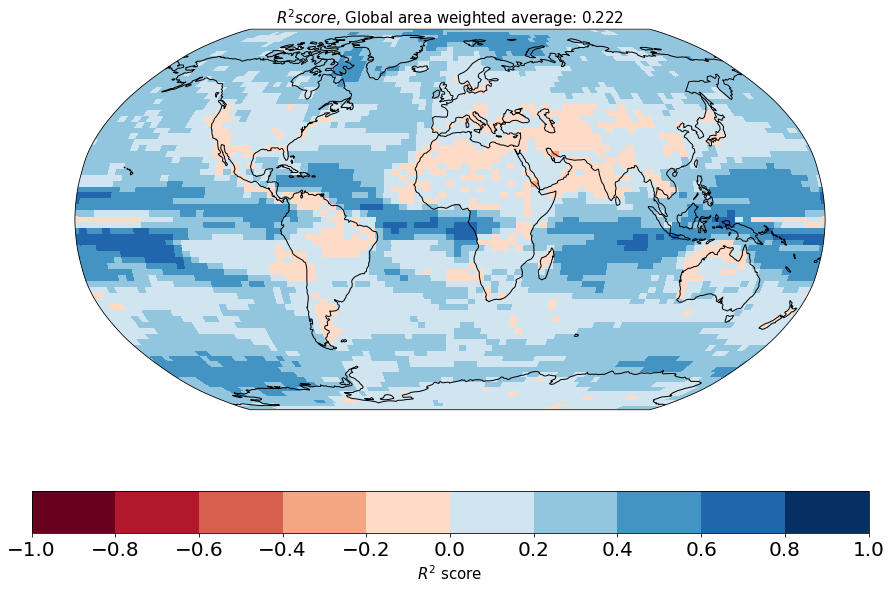

MODELTYPE UNet_flat
MSELoss
Twice interpolated True
True
True
0.146 +/- 0.006


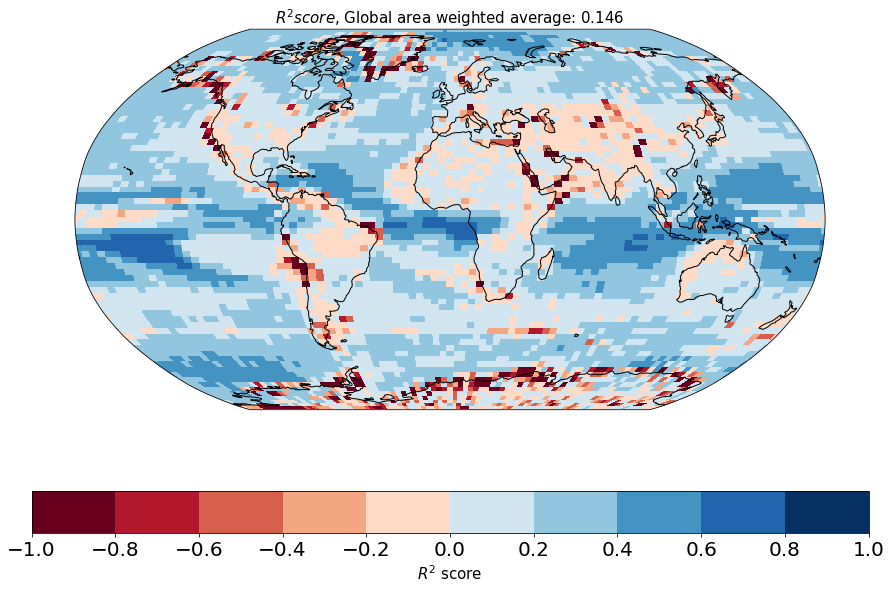

MODELTYPE UNet_flat
MSELoss
Twice interpolated False
True
True
0.232 +/- 0.005


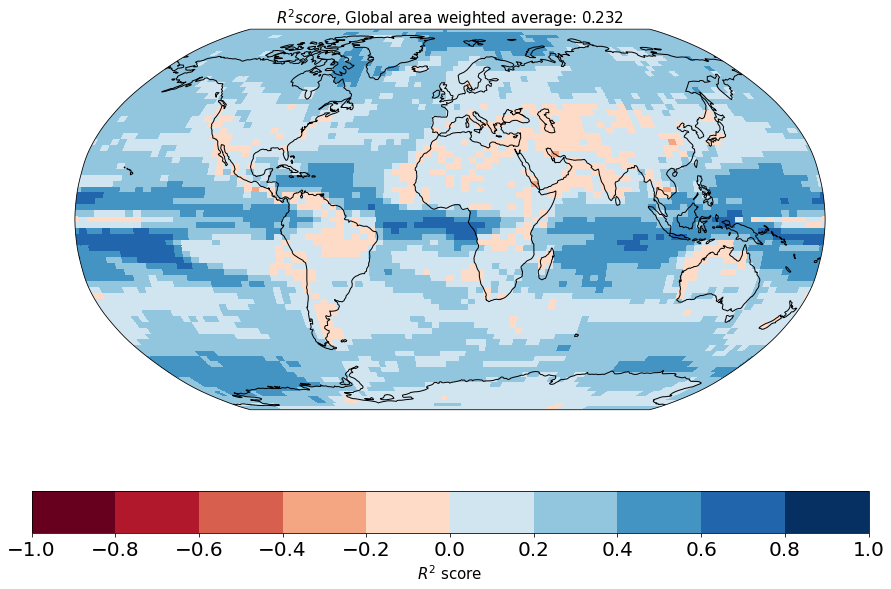

MODELTYPE UNet_flat
AreaWeightedMSELoss
Twice interpolated True
True
True
0.151 +/- 0.002


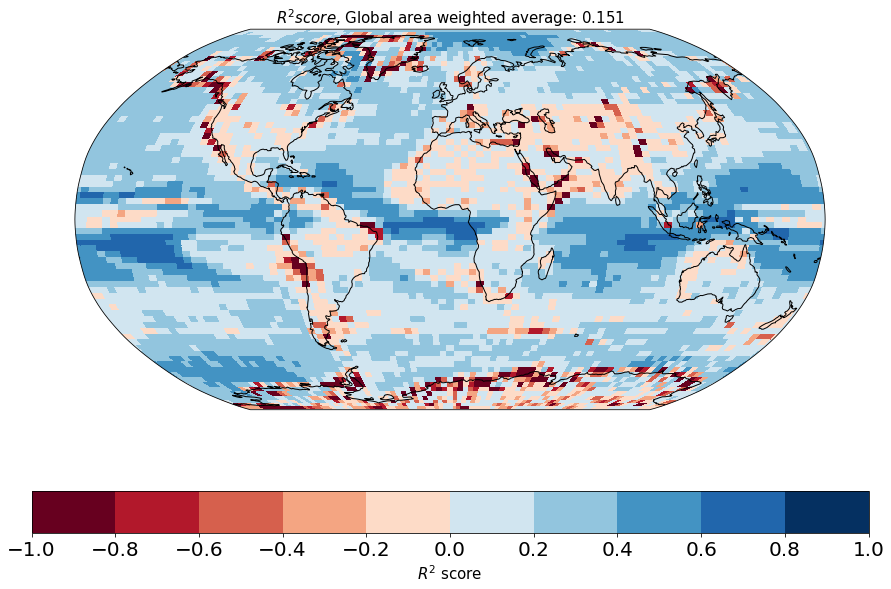

MODELTYPE UNet_flat
AreaWeightedMSELoss
Twice interpolated False
True
True
0.237 +/- 0.001


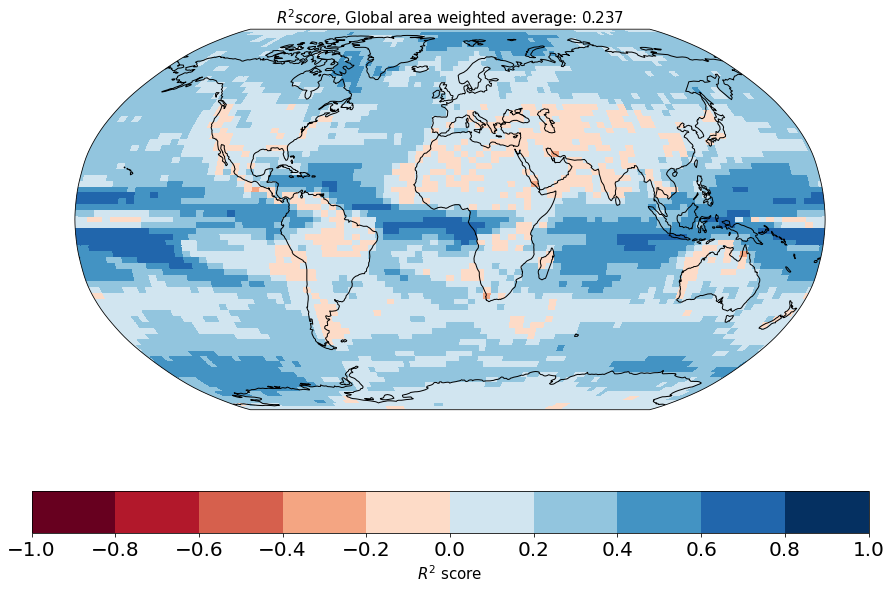

MODELTYPE Classical_flat
0.093 +/- 0.000


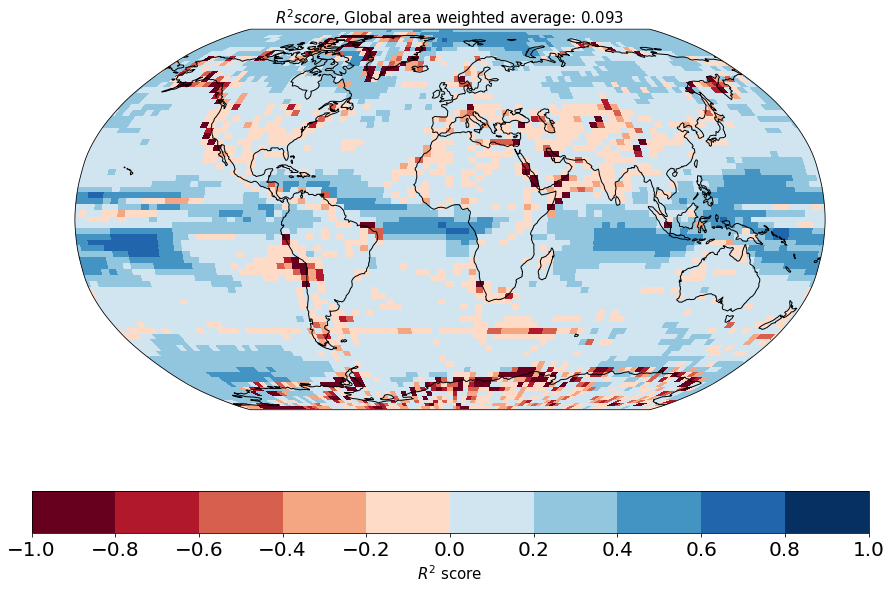

MODELTYPE Classical_flat
0.175 +/- 0.000


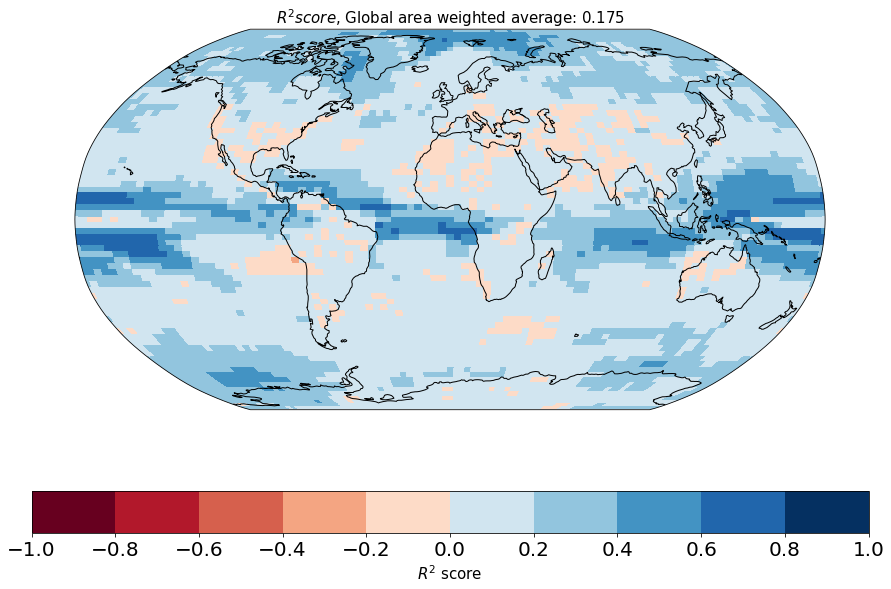

In [23]:
for i, g in enumerate(groups):
    print("MODELTYPE", model_descriptions[g]["MODELTYPE"])
    if "USE_COORD_CONV" in model_descriptions[indices_groups[i][0]].keys():
        print(model_descriptions[indices_groups[i][0]]["loss"])
        print("Twice interpolated",model_descriptions[indices_groups[i][0]]["twice_interpolated"])
        print(model_descriptions[indices_groups[i][0]]["USE_CYLINDRICAL_PADDING"])
        print(model_descriptions[indices_groups[i][0]]["USE_COORD_CONV"])
    print("{:.3f}".format(global_mean[i]), "+/-", "{:.3f}".format(global_std[i]))
    plot_explained_variance(av_metric[i], lat[0],lon[0])#, savename="flat_coord_conv_{}.jpg".format(i))
    plt.show()

In [25]:
"""
important indices:
0: UNet, ico
1: Classical, ico
3: UNet, flat, no modifications
6: UNet, flat, twice interpolated all modifications
7: UNet, flat, all modifications
9: Classical, flat
"""
print()

In [26]:
i_images = [0,1,3,6,7,9]
labels_images = ["ico_unet_flat_grid", "ico_baseline_flat_grid", "flat_unet_unmodified_flat_grid", "flat_unet_modified_2xinterpolated_flat_grid", "flat_unet_modified_flat_grid", "flat_baseline_flat_grid"]

MODELTYPE Classical_flat
0.152 +/- 0.006


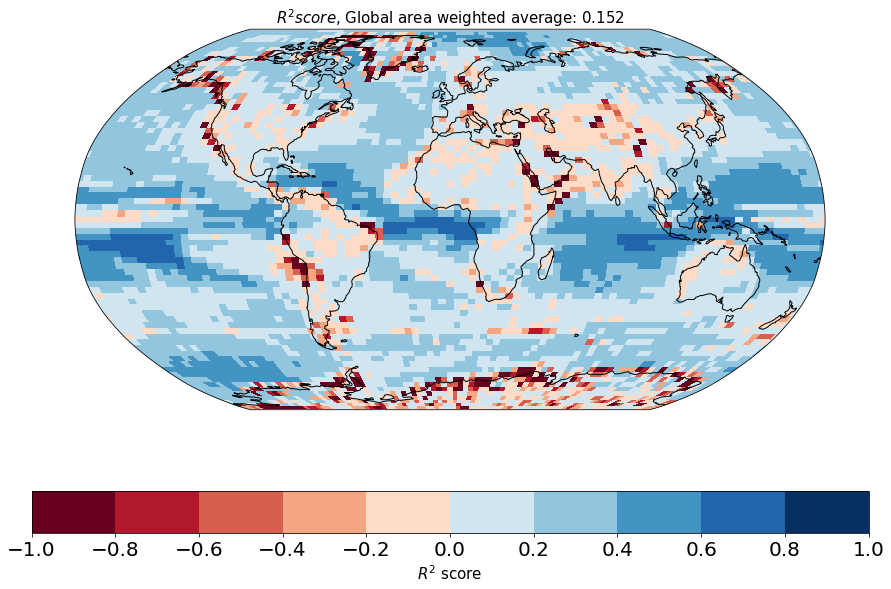

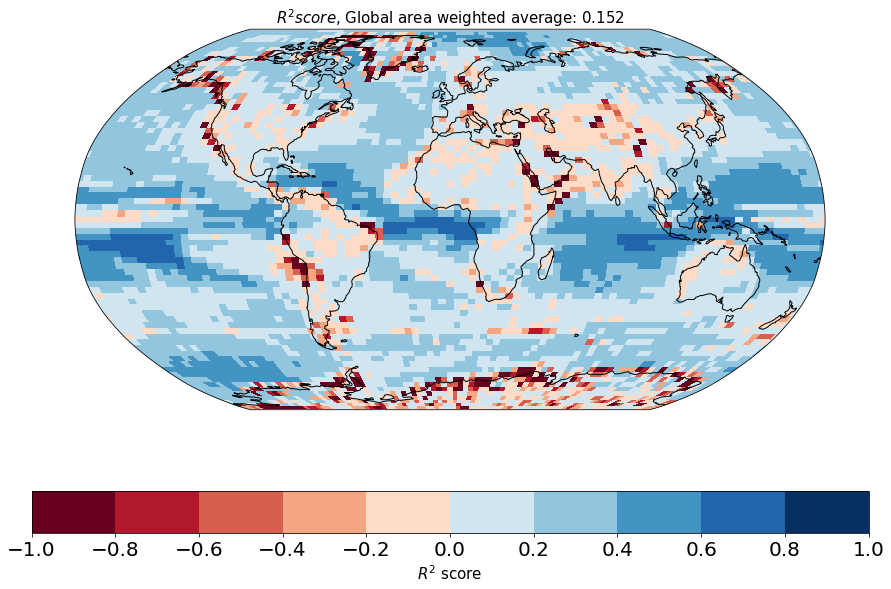

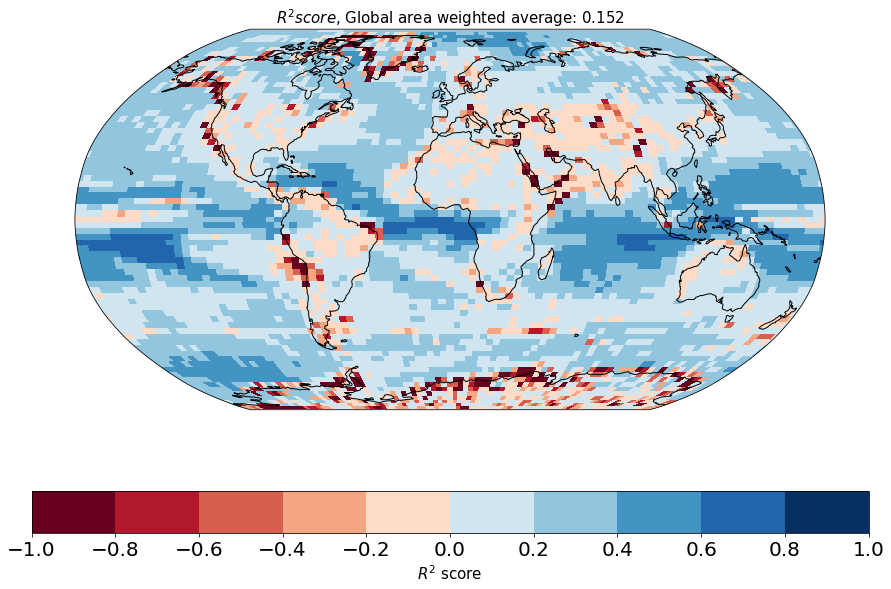

MODELTYPE Classical_flat
0.123 +/- 0.000


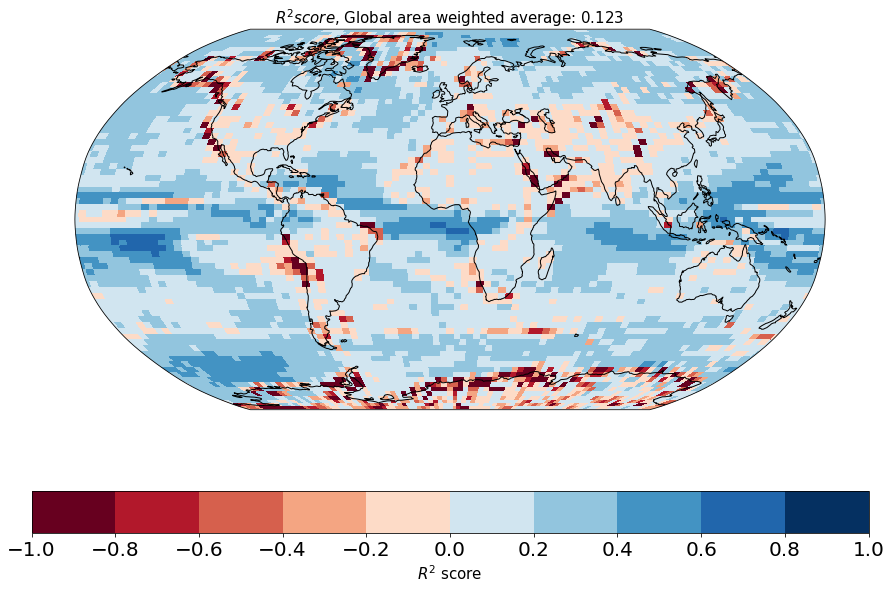

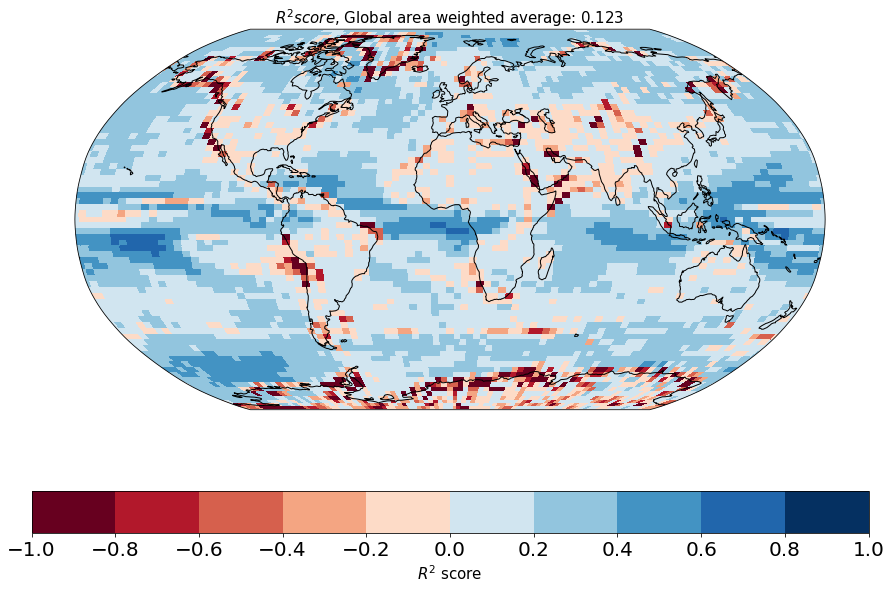

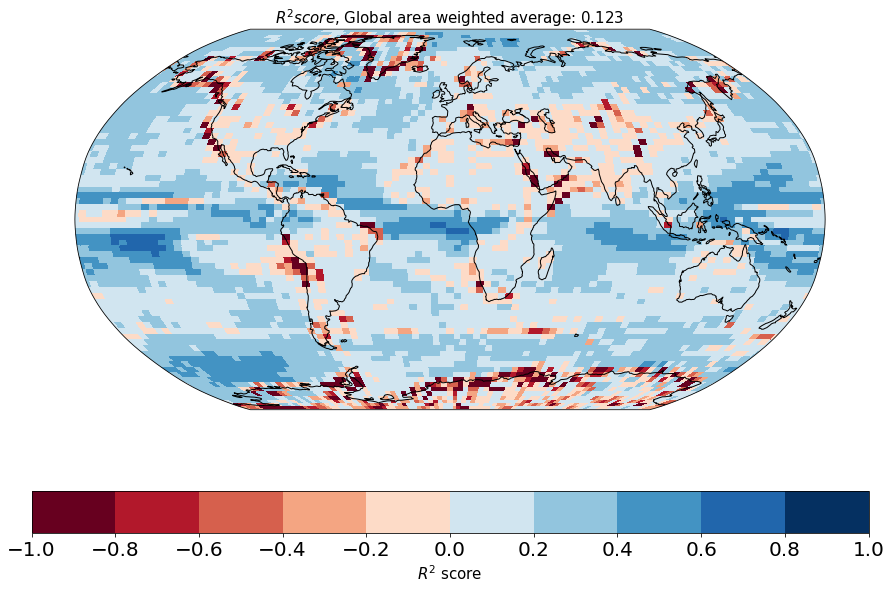

MODELTYPE Classical_flat
MSELoss
Twice interpolated False
False
False
0.222 +/- 0.005


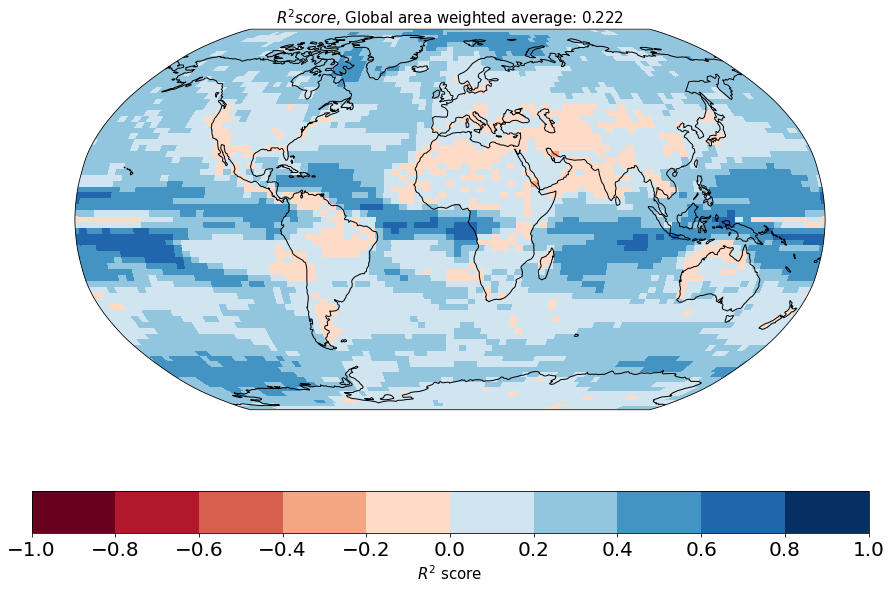

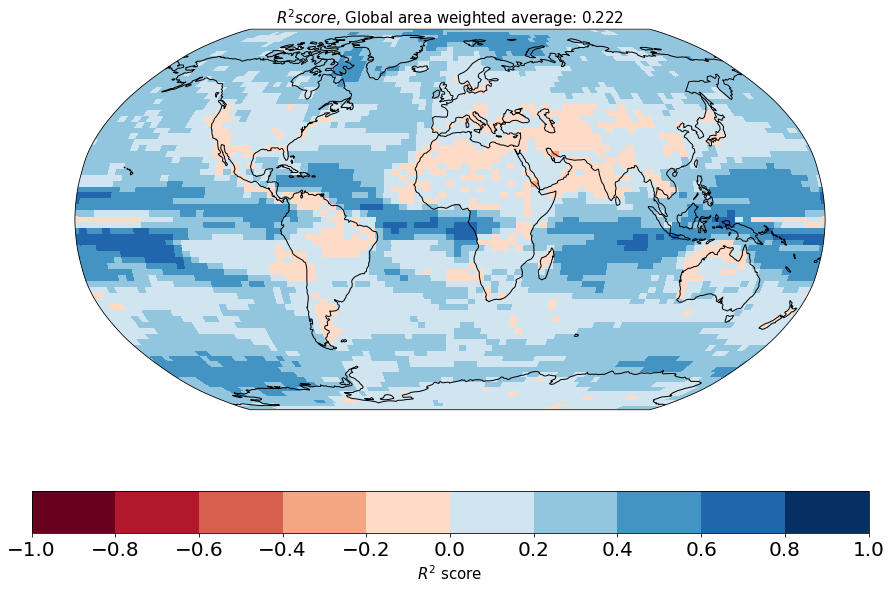

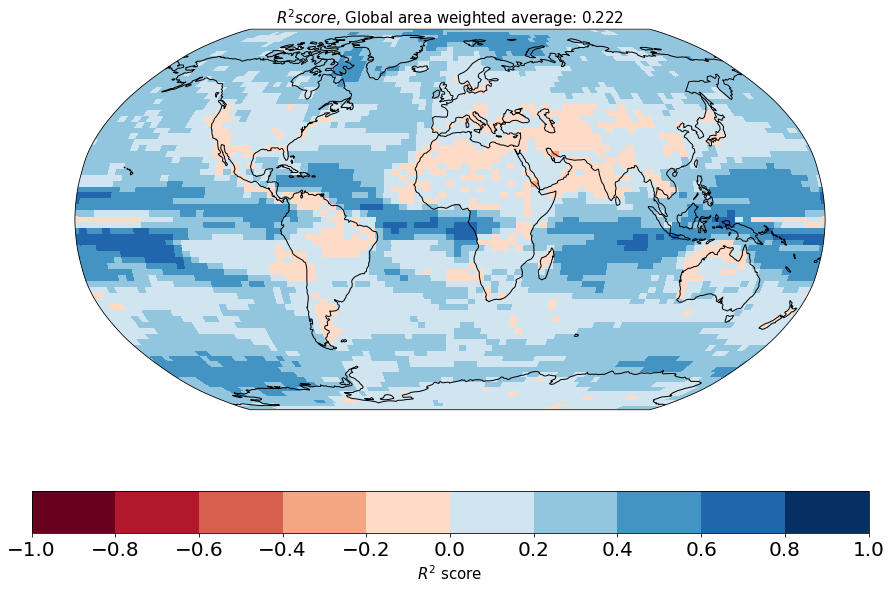

MODELTYPE Classical_flat
AreaWeightedMSELoss
Twice interpolated True
True
True
0.151 +/- 0.002


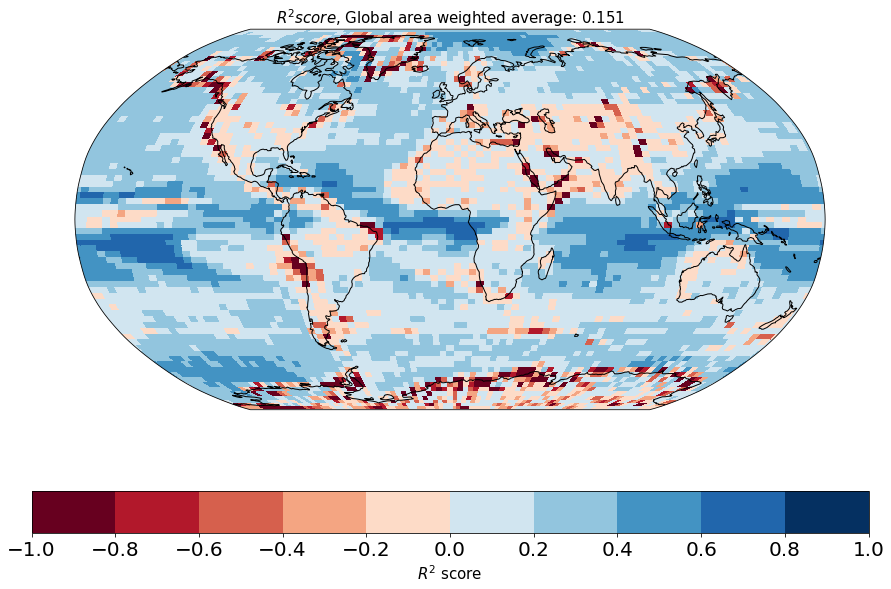

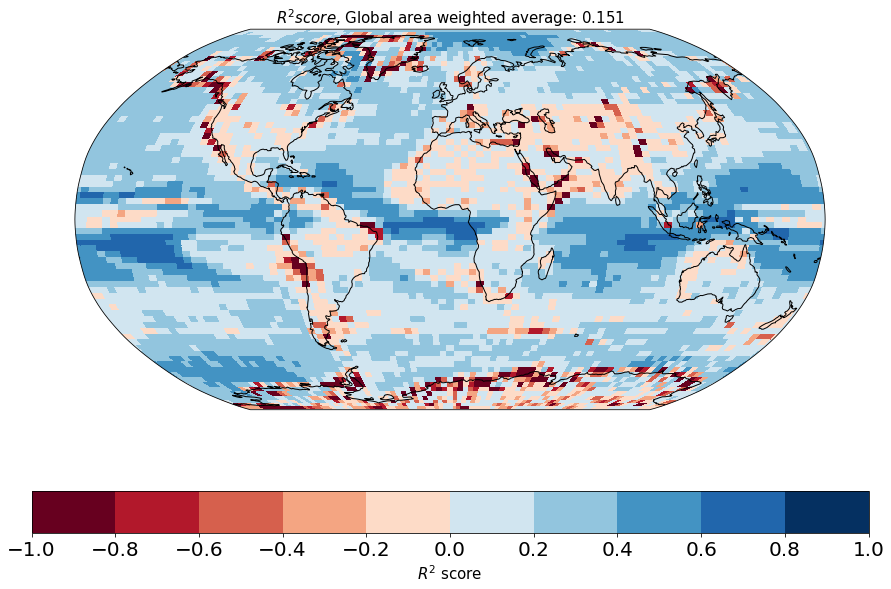

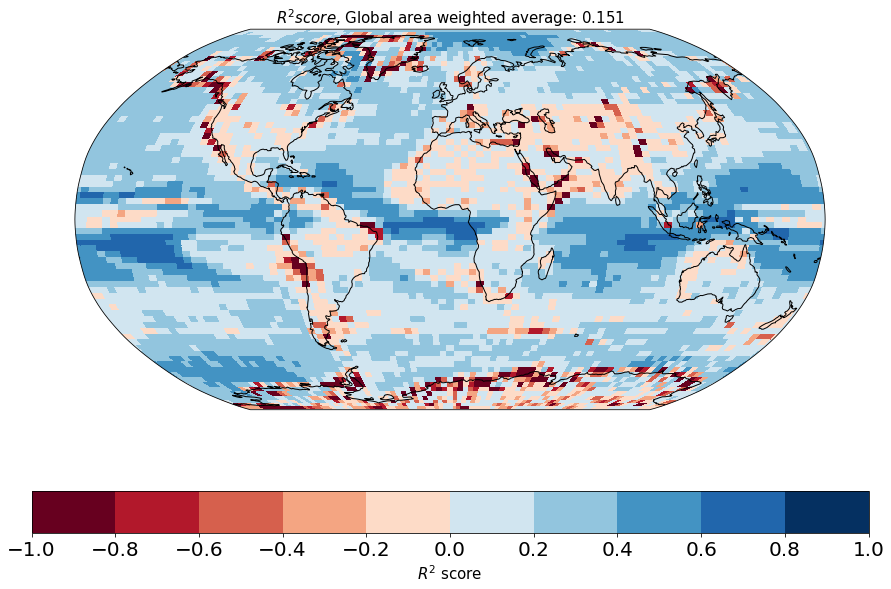

MODELTYPE Classical_flat
AreaWeightedMSELoss
Twice interpolated False
True
True
0.237 +/- 0.001


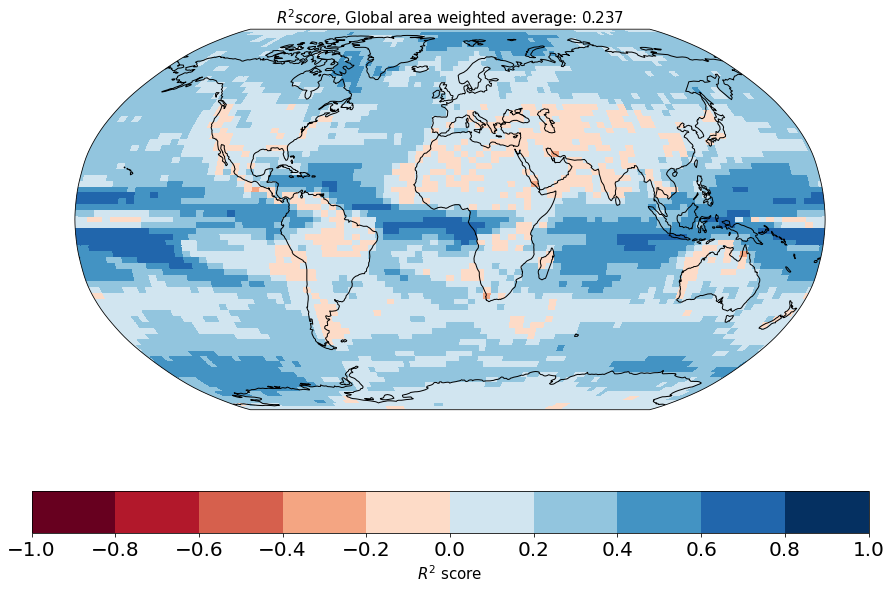

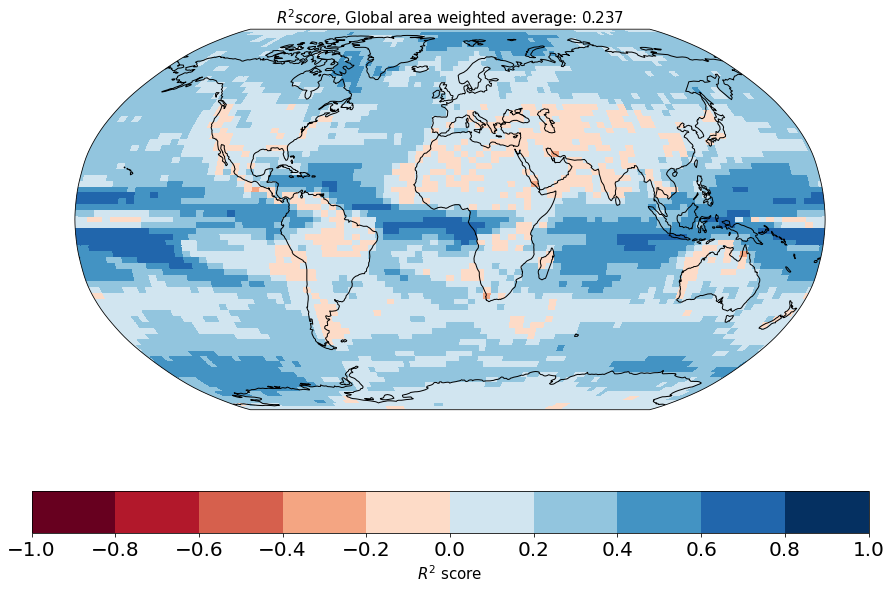

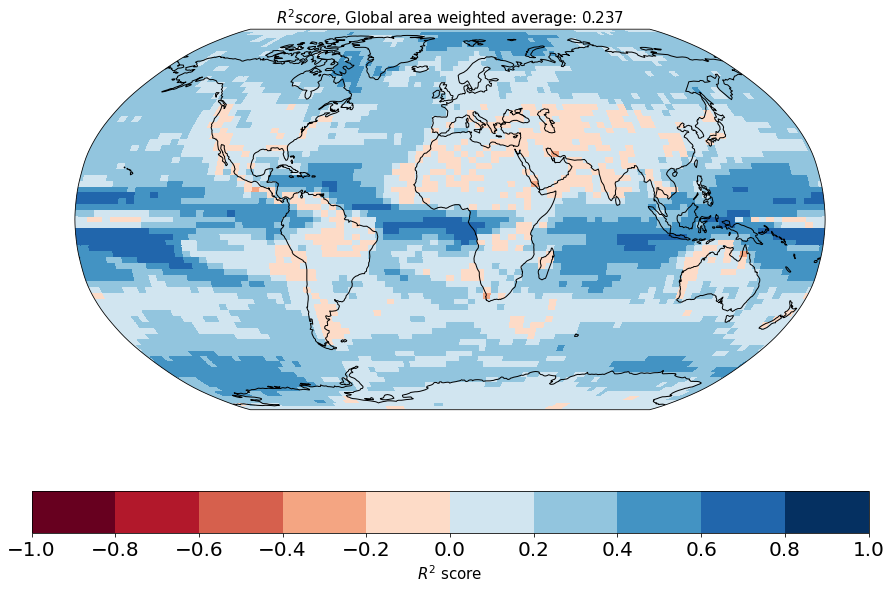

MODELTYPE Classical_flat
0.175 +/- 0.000


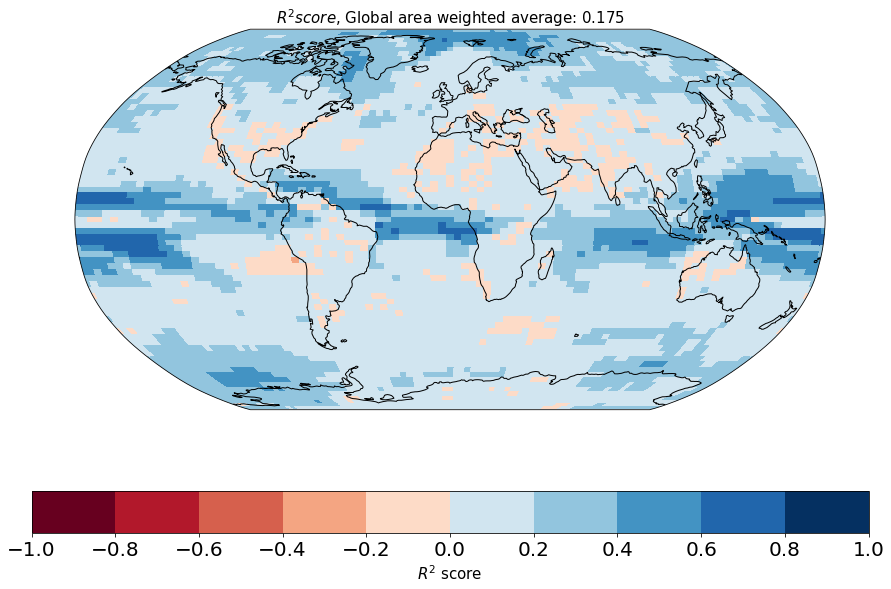

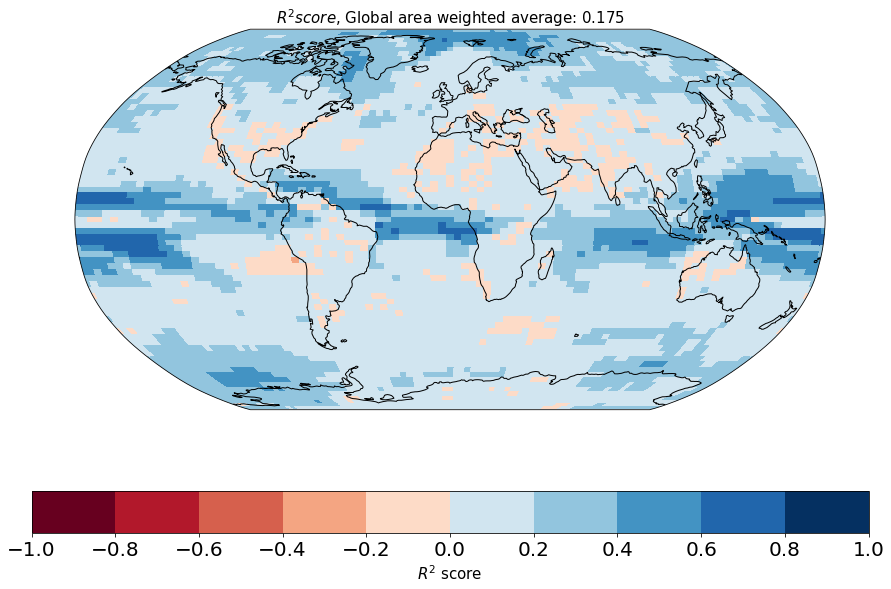

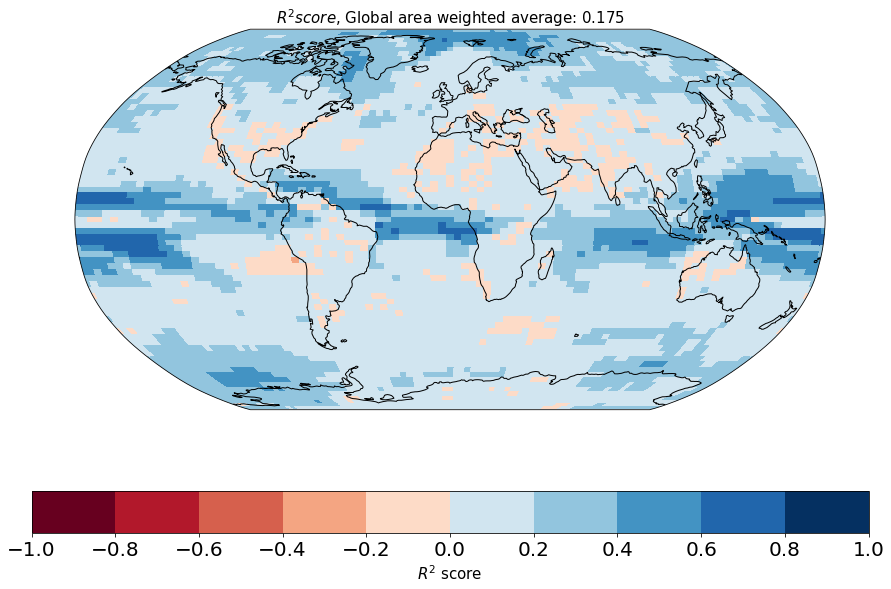

In [27]:
for i, label in zip(i_images, labels_images):
    print("MODELTYPE", model_descriptions[g]["MODELTYPE"])
    if "USE_COORD_CONV" in model_descriptions[indices_groups[i][0]].keys():
        print(model_descriptions[indices_groups[i][0]]["loss"])
        print("Twice interpolated",model_descriptions[indices_groups[i][0]]["twice_interpolated"])
        print(model_descriptions[indices_groups[i][0]]["USE_CYLINDRICAL_PADDING"])
        print(model_descriptions[indices_groups[i][0]]["USE_COORD_CONV"])
    print("{:.3f}".format(global_mean[i]), "+/-", "{:.3f}".format(global_std[i]))
    plot_explained_variance(av_metric[i], lat[0],lon[0], savename="{}.jpg".format(label))
    plot_explained_variance(av_metric[i], lat[0],lon[0], savename="{}.png".format(label))
    plot_explained_variance(av_metric[i], lat[0],lon[0], savename="{}.pdf".format(label))
    plt.show()

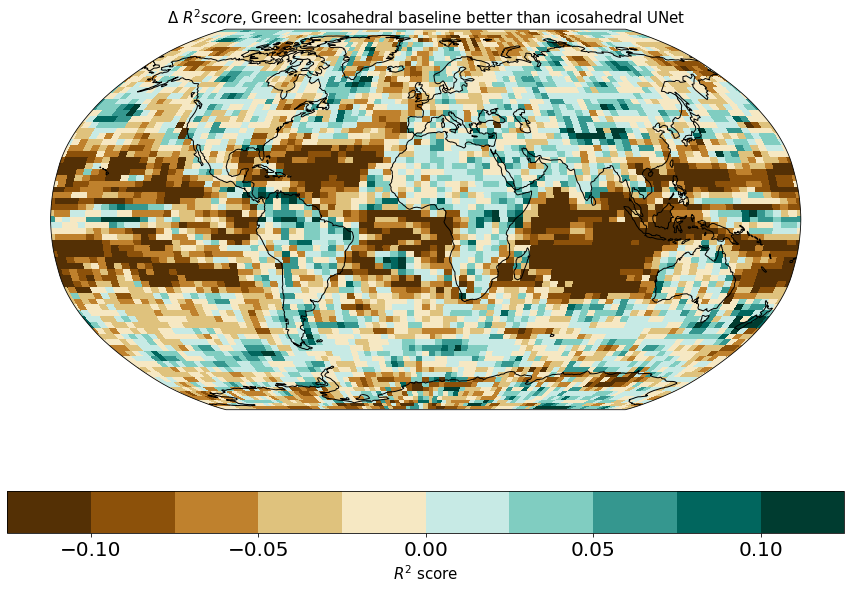

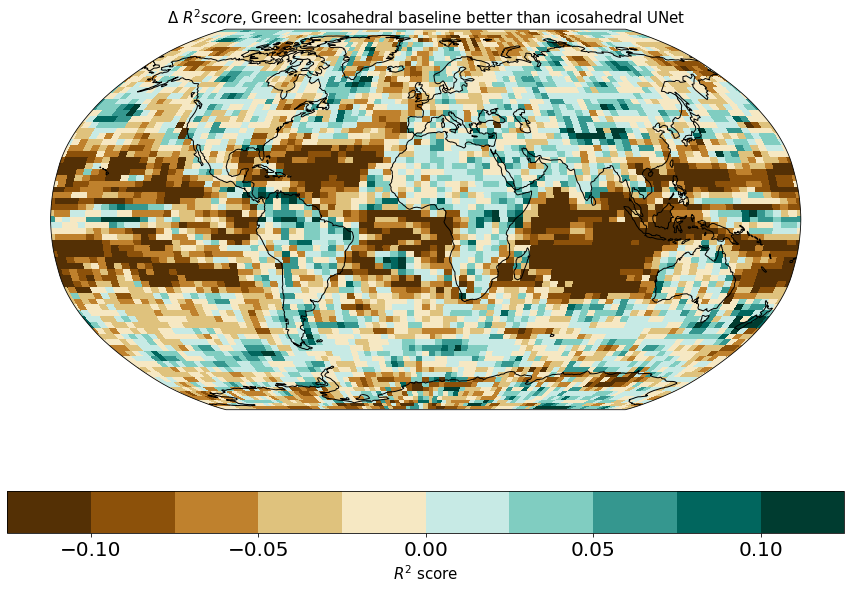

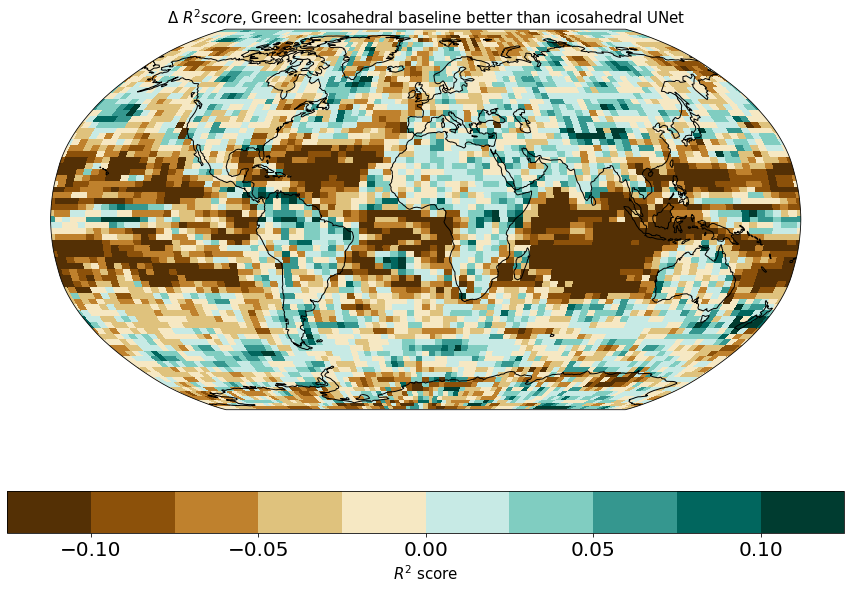

In [28]:
metric_difference = (av_metric[1] - av_metric[0])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Icosahedral baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_ico_baseline_flat_grid.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Icosahedral baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_ico_baseline_flat_grid.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Icosahedral baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_ico_baseline_flat_grid.png")

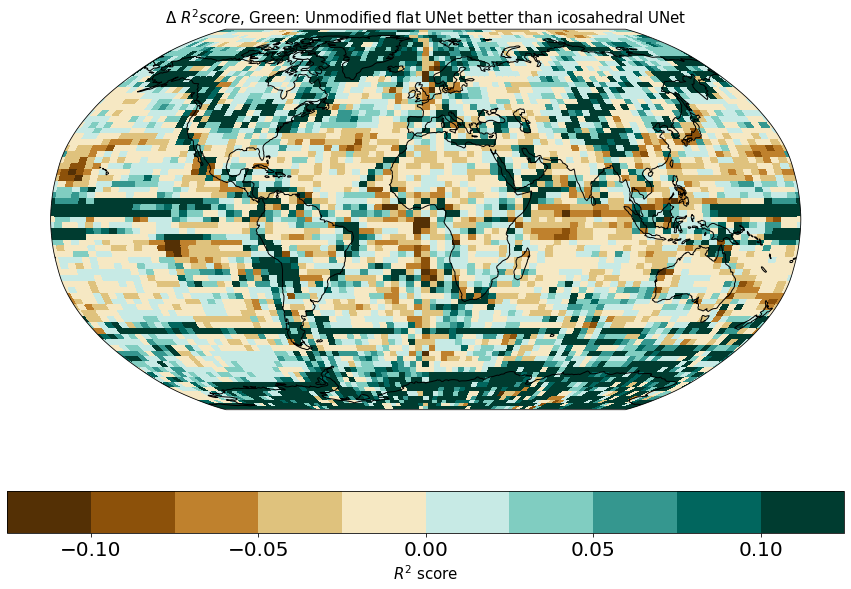

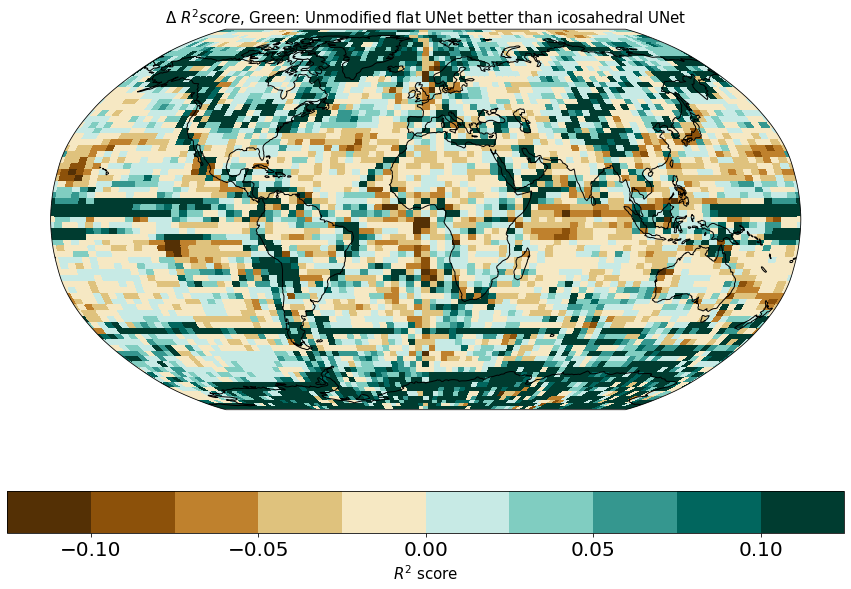

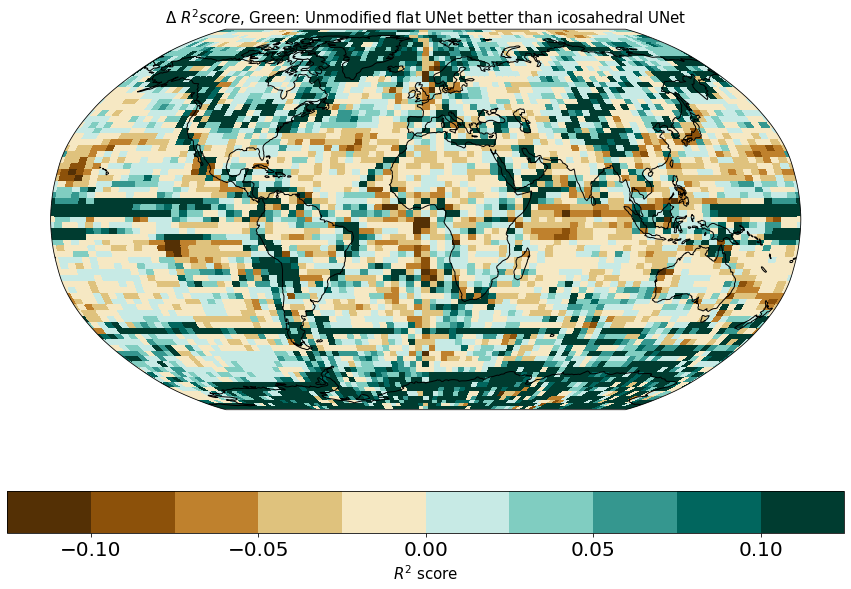

In [29]:
metric_difference = (av_metric[3] - av_metric[0])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Unmodified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_unmodified_flat_unet_flat_grid.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Unmodified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_unmodified_flat_unet_flat_grid.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Unmodified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_unmodified_flat_unet_flat_grid.png")

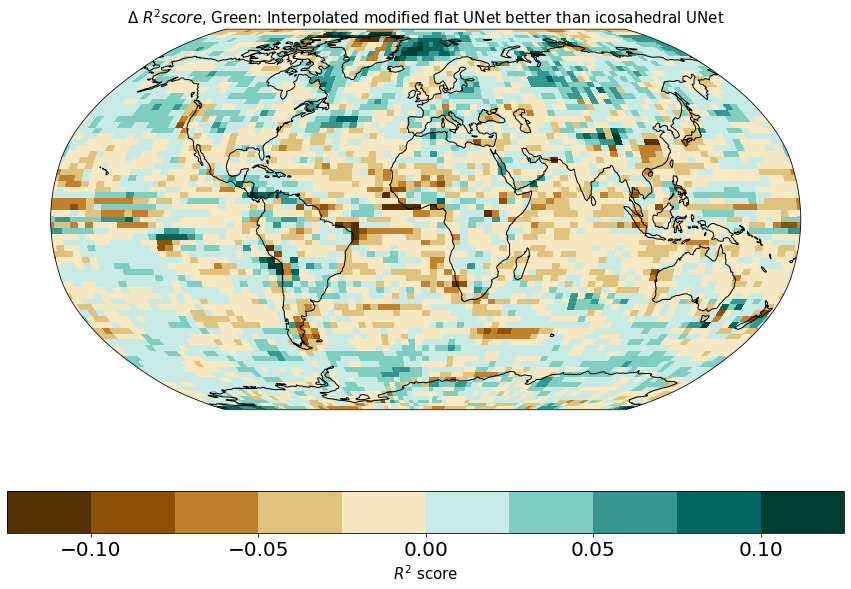

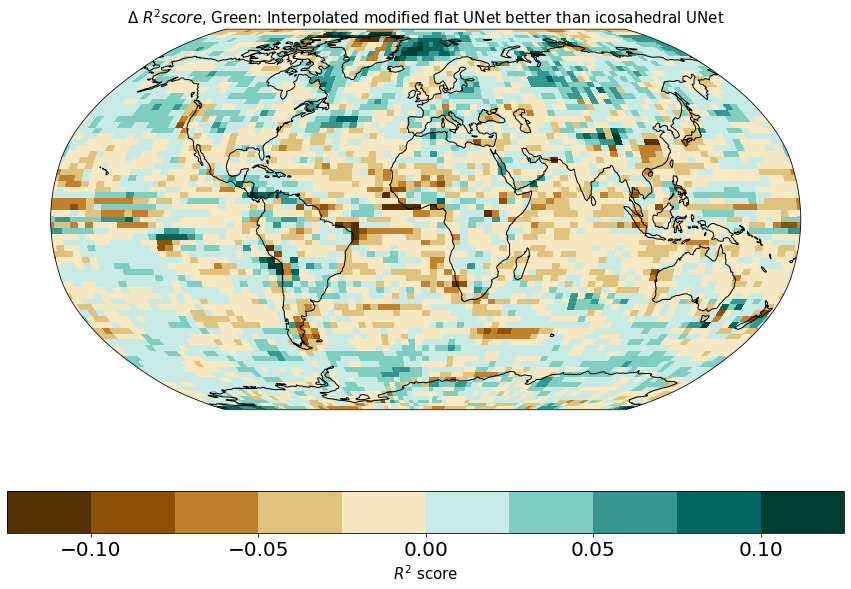

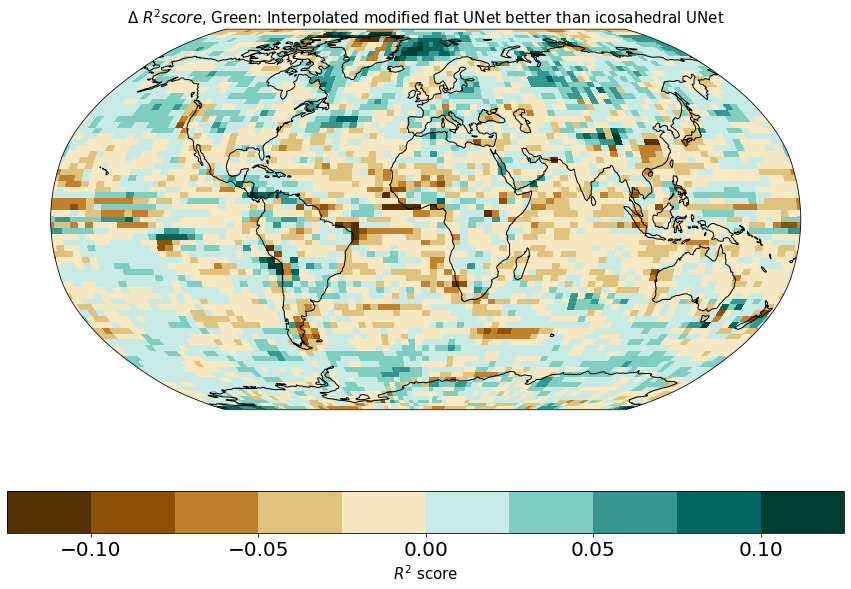

In [30]:
metric_difference = (av_metric[6] - av_metric[0])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Interpolated modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_interpolated_flat_unet_flat_grid.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Interpolated modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_interpolated_flat_unet_flat_grid.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Interpolated modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_interpolated_flat_unet_flat_grid.png")

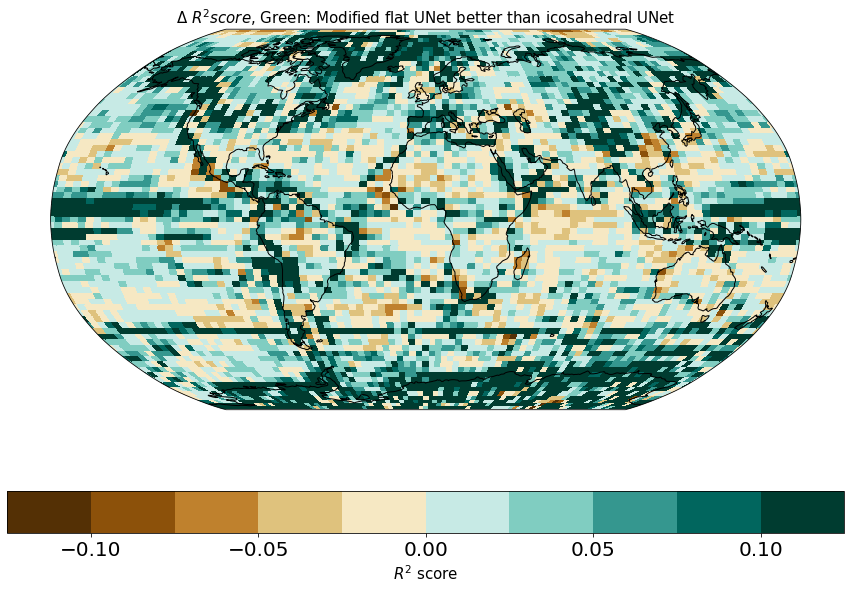

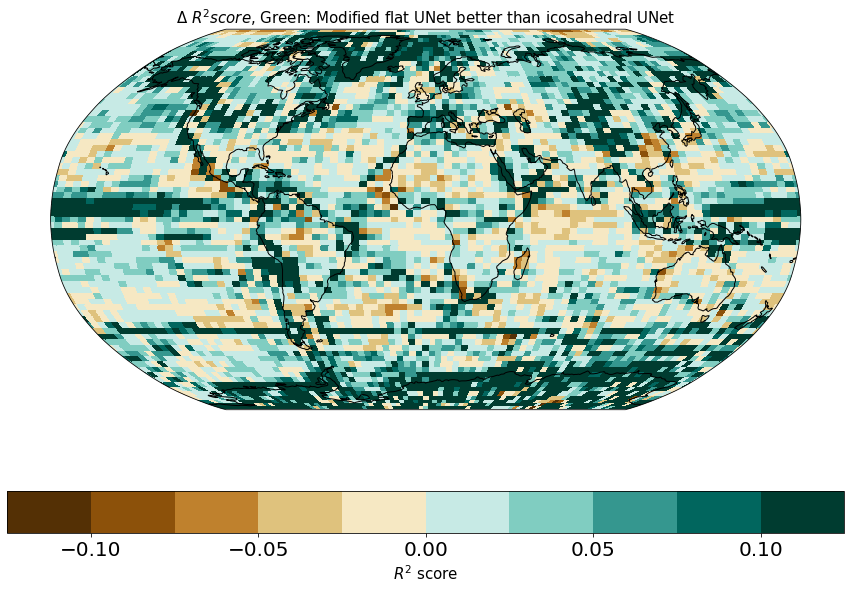

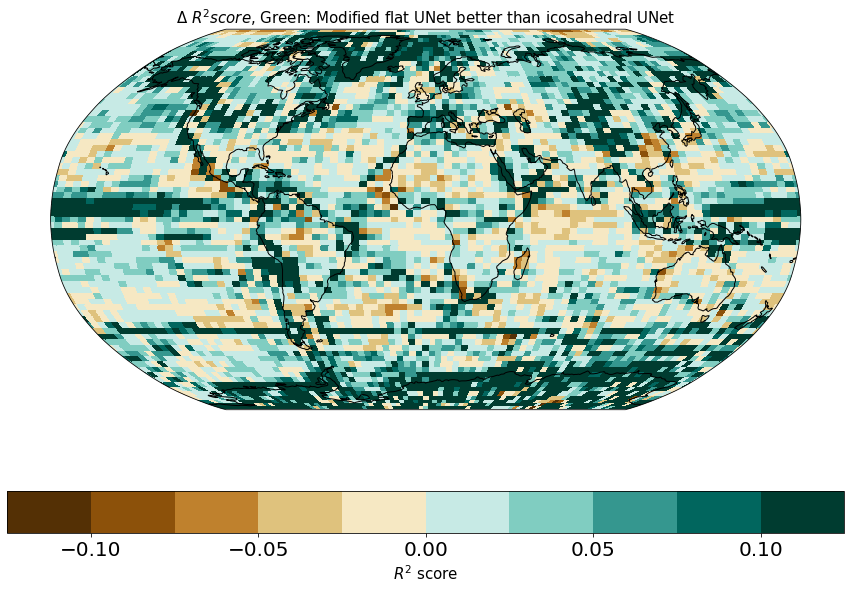

In [31]:
metric_difference = (av_metric[7] - av_metric[0])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_flat_unet_flat_grid.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_flat_unet_flat_grid.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Modified flat UNet better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_modified_flat_unet_flat_grid.png")

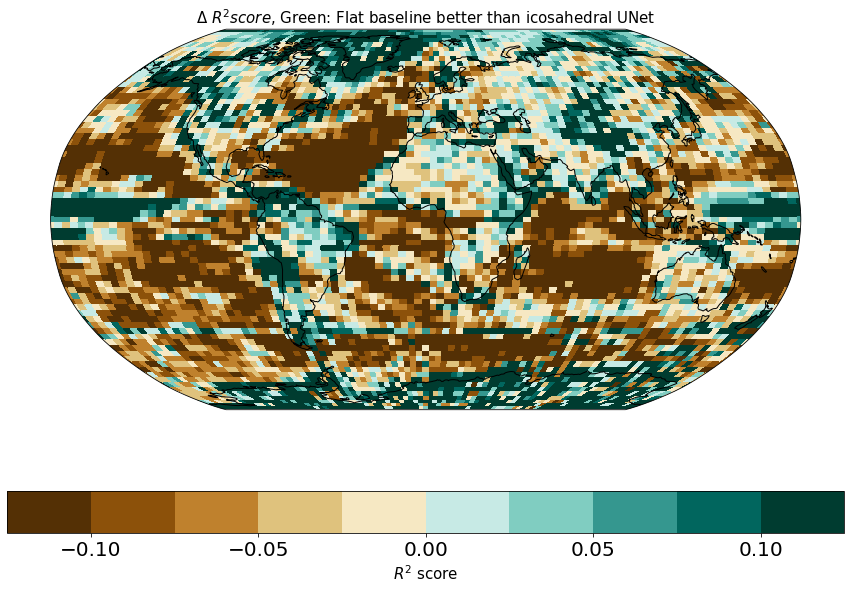

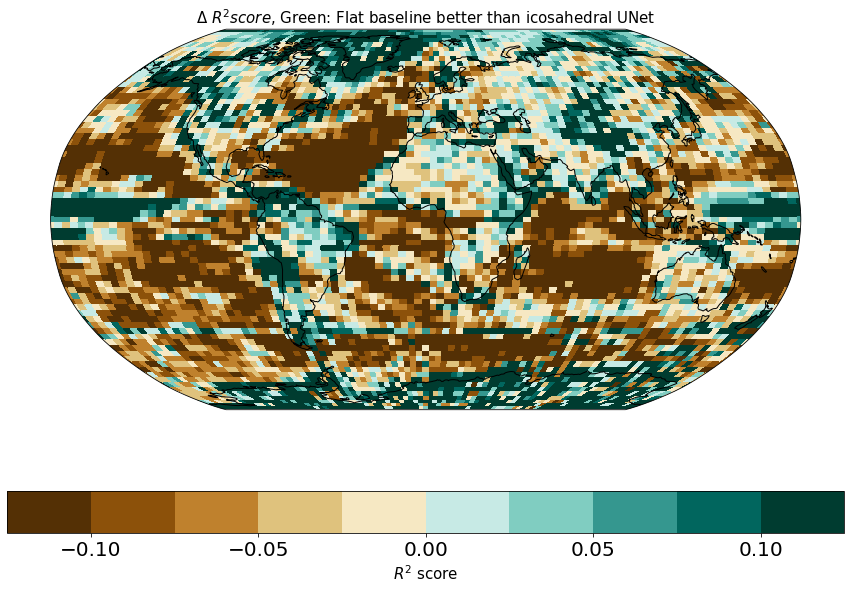

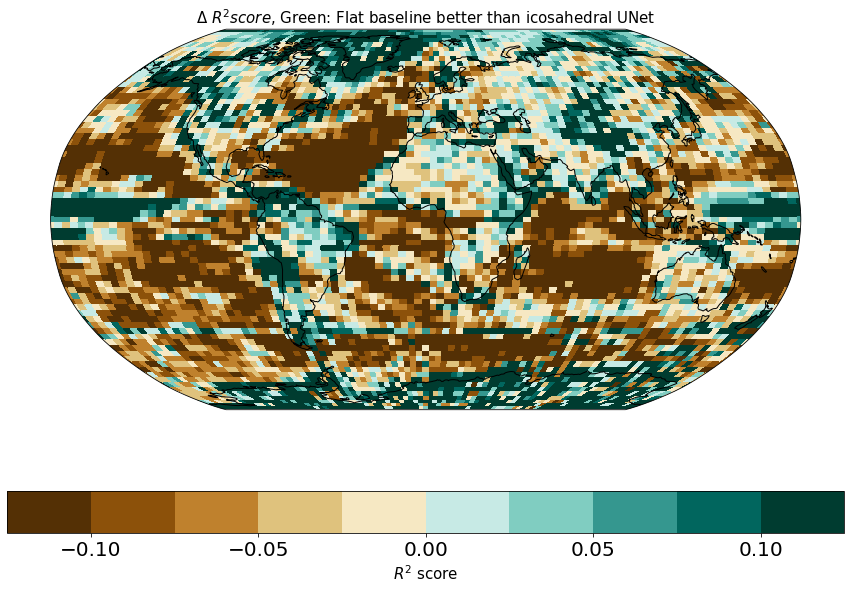

In [32]:
metric_difference = (av_metric[9] - av_metric[0])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than icosahedral UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid.png")

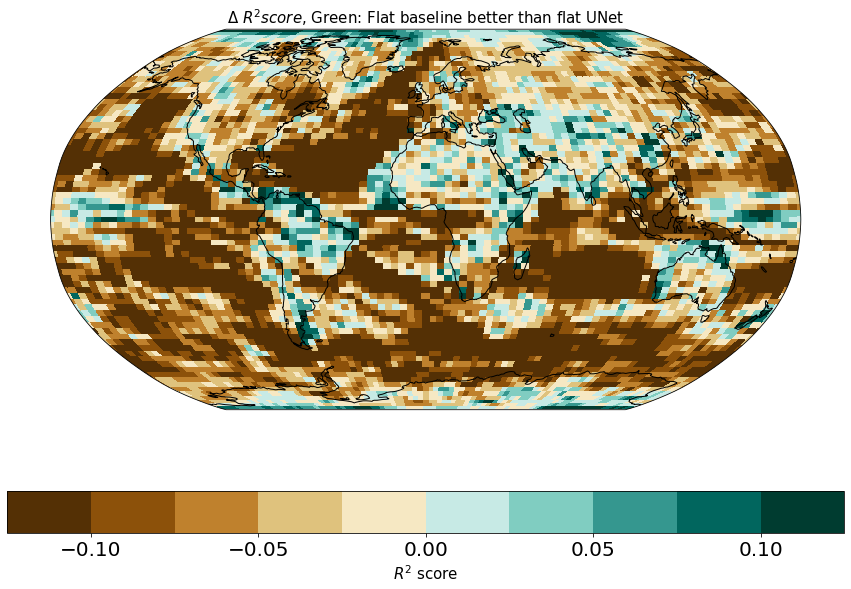

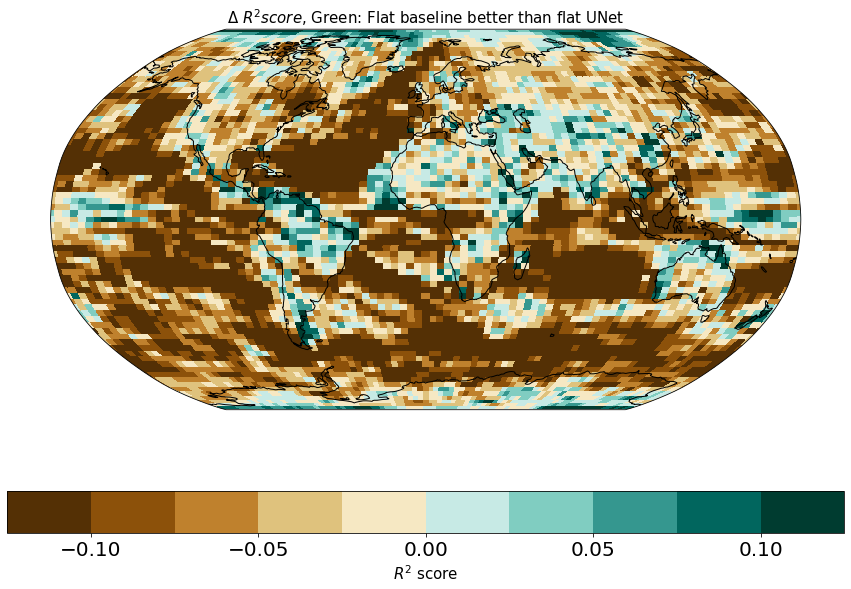

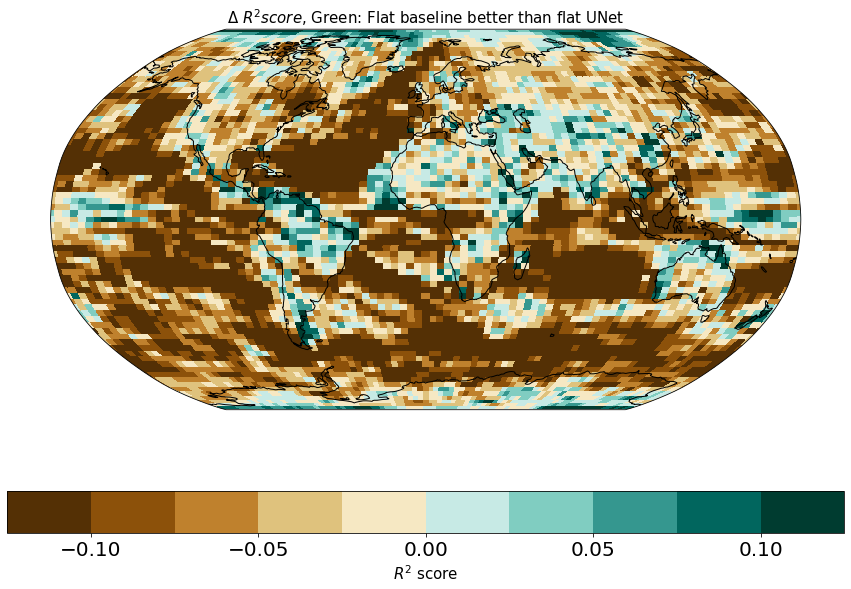

In [33]:
metric_difference = (av_metric[9] - av_metric[7])

bd = max(abs(np.amin(metric_difference)), abs(np.max(metric_difference)))
colors = ["#543005","#8c510a","#bf812d","#dfc27d","#f6e8c3","#c7eae5","#80cdc1","#35978f","#01665e","#003c30"]
cmap= matplotlib.colors.ListedColormap(colors)

norm = matplotlib.colors.Normalize(vmin=-0.125, vmax=+0.125, clip=False)

plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than flat UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid_to_flat_UNet.jpg")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than flat UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid_to_flat_UNet.pdf")
plot_explained_variance(metric_difference, lat[0],lon[0], title="$\Delta$ $R^2 score$, Green: Flat baseline better than flat UNet",\
                        cmap=cmap, norm=norm, use_default_bounds=False, savename="delta_flat_baseline_flat_grid_to_flat_UNet.png")